In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy import sparse
from scipy.sparse.linalg import svds
import implicit

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import matplotlib.pyplot as plt
import json

In [2]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) # topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    # return hit / float(len(_test_set))
    return hit / min(float(len(_test_set)), float(len(_recList)))

def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))

In [3]:
def ugf(scores):
    return np.mean([abs(i[0] - i[1]) for i in combinations(scores, 2)])

## Data preprocessing

In [6]:
df = pd.read_csv('./data/insurance/Train.csv', header=0, sep=',')

In [8]:
df.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,...,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,...,0,0,0,0,0,0,1,1,0,0


In [9]:
df.shape

(29132, 29)

In [10]:
df['ID'].nunique()

29132

In [29]:
df[2010 - df['birth_year'] >= 50].shape

(747, 29)

In [30]:
df[2010 - df['birth_year'] <  50].shape

(28385, 29)

In [18]:
df['occupation_category_code'].unique()

array(['T4MS', '90QI', '56SI', 'JD7X', 'L44T', 'AHH5'], dtype=object)

(array([8.2900e+02, 7.5750e+03, 1.0905e+04, 7.6170e+03, 2.1350e+03,
        6.7000e+01, 2.0000e+00]),
 array([ 0., 15., 25., 35., 45., 55., 65., 75.]),
 <BarContainer object of 7 artists>)

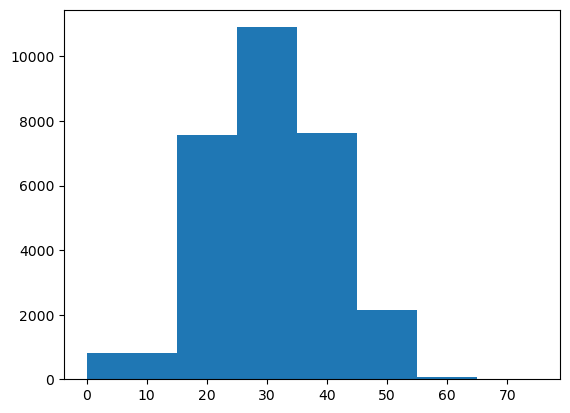

In [28]:
plt.hist(2010-df['birth_year'], bins=[0,15,25,35,45,55,65,75])

In [23]:
np.max(df['birth_year'])

2011